param_num: 275460
[0, 0.4601593017578125, 0.920318603515625, 1.3804779052734375, 1.84063720703125, 2.3007965087890625, 2.760955810546875, 3.2211151123046875, 3.6812744140625, 4.1414337158203125, 4.601593017578125, 5.0617523193359375, 5.52191162109375, 5.9820709228515625, 6.442230224609375, 6.9023895263671875, 7.362548828125, 7.8227081298828125, 8.282867431640625, 8.743026733398438, 9.20318603515625, 9.663345336914062, 10.123504638671875, 10.583663940429688, 11.0438232421875, 11.503982543945312, 11.964141845703125, 12.424301147460938, 12.88446044921875, 13.344619750976562, 13.804779052734375, 14.264938354492188, 14.72509765625, 15.185256958007812, 15.645416259765625, 16.105575561523438, 16.56573486328125, 17.025894165039062, 17.486053466796875, 17.946212768554688, 18.4063720703125, 18.866531372070312, 19.326690673828125, 19.786849975585938, 20.24700927734375, 20.707168579101562, 21.167327880859375, 21.627487182617188, 22.087646484375, 22.547805786132812, 23.007965087890625, 23.468124389

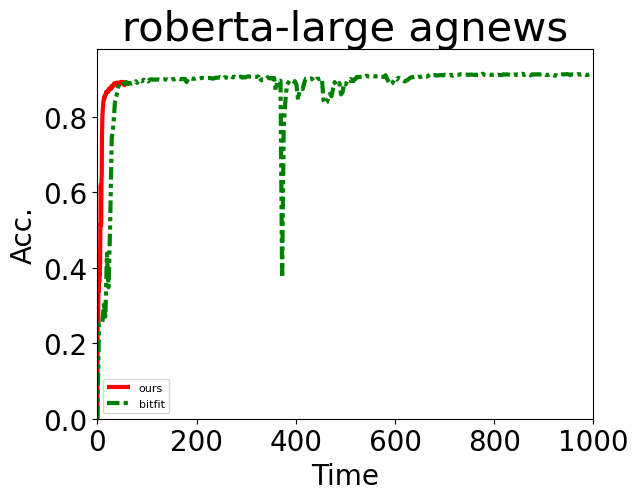

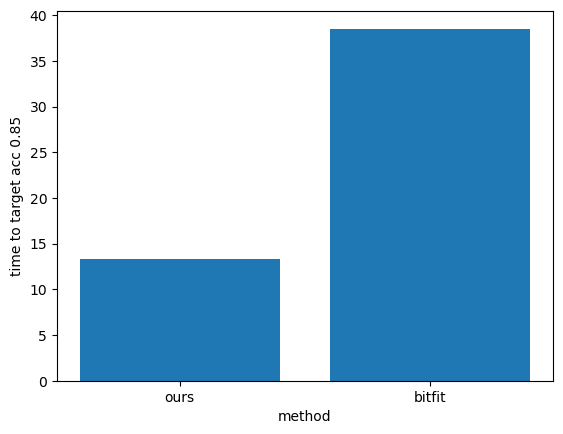

In [2]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "agnews"
model = "roberta-large"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedFwd_roberta-large_agnews_lr0.01_client_num_1000_numerical.log",
    # "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_bitfit.log",
    # "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":1,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.85
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()

param_num: 275460
[0, 2.2101593017578125, 4.420318603515625, 6.6304779052734375, 8.84063720703125, 11.050796508789062, 13.260955810546875, 15.471115112304688, 17.6812744140625, 19.891433715820312, 22.101593017578125, 24.311752319335938, 26.52191162109375, 28.732070922851562, 30.942230224609375, 33.15238952636719, 35.362548828125, 37.57270812988281, 39.782867431640625, 41.99302673339844, 44.20318603515625, 46.41334533691406, 48.623504638671875, 50.83366394042969, 53.0438232421875, 55.25398254394531, 57.464141845703125, 59.67430114746094, 61.88446044921875, 64.09461975097656, 66.30477905273438, 68.51493835449219, 70.72509765625, 72.93525695800781, 75.14541625976562, 77.35557556152344, 79.56573486328125, 81.77589416503906, 83.98605346679688, 86.19621276855469, 88.4063720703125, 90.61653137207031, 92.82669067382812, 95.03684997558594, 97.24700927734375, 99.45716857910156, 101.66732788085938, 103.87748718261719, 106.087646484375, 108.29780578613281, 110.50796508789062, 112.71812438964844, 1

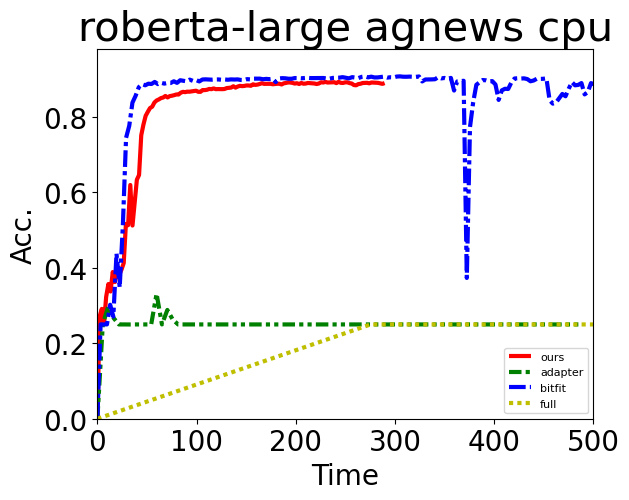

In [1]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "agnews"
model = "roberta-large"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedFwd_roberta-large_agnews_lr0.01_client_num_1000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/roberta-large_agnews/fedsgd_roberta-large_agnews_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":8,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        print(round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc))
        plt.plot(round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc), acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,500)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset} cpu",fontsize=30)
plt.show()